## Creating Custom Networks
In this notebook you have to create a custom network whose architecture has been given, and use the dataset you created earlier to train and test it.

In [199]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import os
from PIL import Image
import unicodedata
from IPython import display
import time

import numpy.linalg as LA
import cv2
# from matplotlib.mlab import PCA
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
use_gpu = True

All hyper parameters go in the next block

In [200]:
batch_size = 1
num_epochs = 20
learning_rate = 0.01
reg_lambda = 0.0000003
crop_res = (112, 112)


In [201]:

windowStride = (16,16)

# winSize = (40, 40)
# blockSize = (20,20)
# blockStride = (10,10)
# cellSize = (5,5)

winSize = (40,40)#(image_size[0]/2,image_size[1]/2)
blockSize = (20,20)
blockStride = (10,10)
cellSize = (5,5)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog_size = 1296 # as observed
num_data_patches = 66920
num_patches_per_image = 25

Wt_ir = np.identity(hog_size)
Wt_vi = np.identity(hog_size)
mu_ir = 0
mu_vi = 0
data_mean = 0
pca_dims = 1296


In [202]:
def preprocessing(image):
    #image is np.array
    # 	image_size = (80, 100)
    #image = cv2.resize(image, image_size)
    # median blur/filter
    median_blur_amount = 1
    image = cv2.medianBlur(image, median_blur_amount)
    # zero mean normalize
    norm_im = image.astype(np.float32)
    norm_im = (norm_im - norm_im.mean()) / norm_im.std() #zero mean unit variance
    # DOG
    g_blur_tuple = (5,5)
    g_blur_amount1 = 1.0
    g_blur_amount2 = 0.5
    begin_blur = time.time()
    gblur1 = cv2.GaussianBlur(norm_im, g_blur_tuple, g_blur_amount1)
    gblur2 = cv2.GaussianBlur(norm_im, g_blur_tuple, g_blur_amount2)
    image_dog = gblur2 - gblur1
#     print("image_dog")
#     print(image_dog)
    end_blur = time.time()
#     print("Time to get GaussBlur was " + str(end_blur - begin_blur))
    # HOG Descriptors:
   
    img = image_dog*255
    img = np.array(img, dtype=np.uint8)
#     print("img shape")
#     print(img.shape)
#     print(img)
#     nbins = 9
#     derivAperture = 1
#     winSigma = 4.
#     histogramNormType = 0
#     L2HysThreshold = 2.0000000000000001e-01
#     gammaCorrection = 0
#     nlevels = 64
    begin_hog = time.time() # hog
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    #compute(img[, winStride[, padding[, locations]]]) -> descriptors
    winStride = (8,8)
    padding = (8,8)
#     locations = ((winSize[0]/2,winSize[1]/2),)
    locations = ((0,0),)
#     print("locations " + str(locations))
#     print("winst" + str(winStride))
    hist = hog.compute(img,winStride,padding, locations)
#     print(hist.size)
#     print(hist)
    end_hog = time.time() #hog
#     print("Time to get hog was " + str(end_hog - begin_hog))
#     print("hist size" + str(hist.shape))
    return np.transpose(hist)

In [203]:
# def computePCA(  train=True):
    
#     root_dir = "./images"
#     if(train == True):
#             rd_walk = root_dir + "/train/Visible"
#     else:
#         rd_walk = root_dir + "/test"
#     ir_projs = np.zeros((1,winSize[0], winSize[1]))
#     vi_projs = np.zeros((1,winSize[0], winSize[1]))
#     file_map = list()
#     rd = root_dir + "/train/"
#     i=0
#     j=0
#     vi_projs = np.zeros((num_data_patches, hog_size))
#     ir_projs = np.zeros((num_data_patches, hog_size))
#     begin_walk = time.time()
#     for subdir, dirs, files in os.walk(rd_walk):
#         for File in files:
#             print(str(i) + "\t\t" + File)
#             i = i+1
#             lab = int(File.split('_')[0])  
#             (x, y, w, h) = (int(File.split('_')[1]), int(File.split('_')[2]), int(File.split('_')[3]), int(File.split('_')[4]))              
#             file_map = file_map + [(File, lab, (x, y, w, h))]
            
#             ir_img = Image.open(rd + "Infrared/" + File).convert('RGB')
#             vi_img = Image.open(rd + "Visible/" + File).convert('RGB')
#             ir_img = np.array(ir_img)
#             vi_img = np.array(vi_img)
#             ir_img = ir_img[y: y+h, x: x+w]
#             vi_img = vi_img[y: y+h, x: x+w]
#             ir_img = np.resize(ir_img, crop_res)
#             vi_img = np.resize(vi_img, crop_res)


#             stride_1 = windowStride[0]
#             stride_2 = windowStride[1]
#             point_set = set((a,b) for a in range(0,crop_res[1] - winSize[1], stride_1) for b in range(0,crop_res[0] - winSize[0],stride_2))
#             print("point set len is "+str(len(point_set)))
            
#             begin_patching = time.time()
#             for cx,cy in point_set:
#                 area = (cy, cx, cy + winSize[0], cx + winSize[1])
#                 # area_set = area_set + [area]
#                 ir_patch = ir_img[cy:cy+winSize[0], cx:cx+winSize[1]]
#                 vi_patch = vi_img[cy:cy+winSize[0], cx:cx+winSize[1]]
#                 ir_hog = preprocessing(ir_patch) #return row vector
#                 vi_hog = preprocessing(vi_patch)
#                 ir_projs[j] = ir_hog
#                 vi_projs[j] = vi_hog
#                 j=j+1
# #                 ir_projs = np.append(ir_hog, ir_projs)
# #                 vi_projs = np.append(vi_hog, vi_projs)
# #                 print(ir_projs.shape, ir_hog.shape)
# #                 ir_patch = np.reshape(ir_patch, (1,winSize[0], winSize[1]))
# #                 vi_patch = np.reshape(vi_patch, (1,winSize[0], winSize[1]))
                
# #                 ir_projs = np.concatenate((ir_projs, ir_patch), axis=0)  # the most expensive process
# #                 vi_projs = np.concatenate((vi_projs, vi_patch), axis=0)
#             end_patching = time.time()
# #             print("time to make patches: " + str(end_patching - begin_patching))
#     end_walk = time.time()
#     print("Toatal walk in files time: " + str(end_walk - begin_walk))
#     print(j)
#     print("Now Computing PCA for ir")
#     print(np.isfinite(ir_projs).all())
# #     result = PCA(ir_projs, standardize=False)
#     pca_ir = PCA(n_components = 64)
#     pca_ir.fit(ir_projs)
#     print(pca_ir.components_)
# #     Wt_ir = result.Wt
# #     mu_ir = result.mu
# #     print(Wt_ir)
#     print("Now Computing PCA for vi")
    
#     pca_vi = PCA(n_components = 64)
#     pca_vi.fit(vi_projs)
#     print(pca_vi.components_)
# #     result = PCA(vi_projs, standardize=False)
#     print("Done PCA!")
# #     Wt_vi = result.Wt
# #     mu_vi = result.mu
# #     print(Wt_vi)
#     return ( Wt_ir, Wt_vi, mu_ir, mu_vi) 
    
            

In [204]:
#%time ( Wt_ir, Wt_vi, mu_ir, mu_vi) =  computePCA()

In [205]:
# print(Wt_ir)
# print(Wt_vi)

### Create Custom Dataset and Loader
This is the same as part 1. Simply use the same code to create the dataset.

In [206]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # root_dir  - the root directory of the dataset
        # train     - a boolean parameter representing whether to return the training set or the test set
        # transform - the transforms to be applied on the images before returning them
        #
        # In this function store the parameters in instance variables and make a mapping
        # from images to labels and keep it as an instance variable. Make sure to check which
        # dataset is required; train or test; and create the mapping accordingly.
        self.root_dir = root_dir
        self.train = train
        self.transform  = transform
        self.map = list()
        
        if(train == True):
            rd = root_dir + "/train/Visible"
        else:
            rd = root_dir
            
        for subdir, dirs, files in os.walk(rd):
            for File in files:
                lab = int(File.split('_')[0])  
                (x, y, w, h) = (int(File.split('_')[1]), int(File.split('_')[2]), int(File.split('_')[3]), int(File.split('_')[4]))              
                self.map = self.map + [(File, lab, (x, y, w, h))]
                
        
            
        
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        return len(self.map)
    
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        if(self.train==1):
            rd = self.root_dir + "/train"
            ir_img = Image.open(rd + "/Infrared/" + self.map[idx][0]).convert('L')
            vi_img = Image.open(rd + "/Visible/" + self.map[idx][0]).convert('L')
            (x, y, w, h) = self.map[idx][2]
            ir_img = ir_img.crop((x,y,x+w,y+h))
            vi_img = vi_img.crop((x,y,x+w,y+h))
            ir_img = ir_img.resize( crop_res, Image.ANTIALIAS)
            vi_img = vi_img.resize( crop_res, Image.ANTIALIAS)
            ir_img = np.array(ir_img)
            vi_img = np.array(vi_img)
#             cv2.imshow("original image", vi_img)
#             cv2.waitKey(0)

#             ir_img = ir_img[y: y+h, x: x+w]
#             vi_img = vi_img[y: y+h, x: x+w]
#             ir_img = np.resize(ir_img, crop_res)
#             vi_img = np.resize(vi_img, crop_res)
#             print("image_ir")
#             print(ir_img)


            stride_1 = windowStride[0]
            stride_2 = windowStride[1]
            point_set = set((a,b) for a in range(0,crop_res[1] - winSize[1], stride_1) for b in range(0,crop_res[0] - winSize[0],stride_2))
    #             print("point set len is "+str(len(point_set)))
            ir_projs = np.zeros((len(point_set),pca_dims+2))
            vi_projs = np.zeros((len(point_set),pca_dims+2))

            j=0
            (wi, hi) = winSize
            for cx,cy in point_set:
#                 area = (cy, cx, cy + winSize[0], cx + winSize[1])
                # area_set = area_set + [area]
                ir_patch = ir_img[cy:cy+winSize[0], cx:cx+winSize[0]]
                vi_patch = vi_img[cy:cy+winSize[0], cx:cx+winSize[0]]
#                 print("winsize" + str(winSize))
#                 print(ir_patch.shape)
                ir_hog = preprocessing(ir_patch) #return row vector
                vi_hog = preprocessing(vi_patch)
                    # For PCA
#                 ir_proj = np.matmul(ir_hog - mu_ir, Wt_ir[:,:pca_dims]) # Wt = np.transpose(PCA(data).Wt[:pca_dims])
#                 vi_proj = np.matmul(vi_hog - mu_vi, Wt_vi[:,:pca_dims])
                # append x,y 
                ir_proj = np.append(ir_hog, [np.divide((cy+hi/2, cx+wi/2) - np.divide(crop_res,2), crop_res[0])])
                vi_proj = np.append(vi_hog, [np.divide((cy+hi/2, cx+wi/2) - np.divide(crop_res,2), crop_res[0])])
                
#                 print("ir_proj", ir_proj)
                ir_projs[j] = ir_proj
                vi_projs[j] = vi_proj
                j=j+1
    #             ir_projs = np.reshape(ir_projs, (-1, pca_dims))
    #             vi_projs = np.reshape(vi_projs, (-1, pca_dims))

            ir_projs = torch.from_numpy(ir_projs)
            vi_projs = torch.from_numpy(vi_projs)
    #             print(vi_projs.shape)
            return (vi_projs, ir_projs, self.map[idx][1])
    
        else:
            rd = self.root_dir 
            img = Image.open(rd + self.map[idx][0]).convert('L')
            (x, y, w, h) = self.map[idx][2]
            img = img.crop((x,y,x+w,y+h))
            img = img.resize( crop_res, Image.ANTIALIAS)
            img = np.array(img)
            stride_1 = windowStride[0]
            stride_2 = windowStride[1]
            point_set = set((a,b) for a in range(0,crop_res[1] - winSize[1], stride_1) for b in range(0,crop_res[0] - winSize[0],stride_2))
    #             print("point set len is "+str(len(point_set)))
            projs = np.zeros((len(point_set),pca_dims+2))
            j=0
            (wi, hi) = winSize
            for cx,cy in point_set:
#                 area = (cy, cx, cy + winSize[0], cx + winSize[1])
                # area_set = area_set + [area]
                
                patch = img[cy:cy+winSize[0], cx:cx+winSize[0]]
                hog = preprocessing(patch) #return row vector
#                 proj = np.matmul(hog - mu_ir, Wt_ir[:,:pca_dims]) # Wt = np.transpose(PCA(data).Wt[:pca_dims])
                # append x,y 
                proj = np.append(hog, [np.divide((cy+hi/2, cx+wi/2) - np.divide(crop_res,2), crop_res[0])])
                projs[j] = proj
                j=j+1

            projs = torch.from_numpy(projs)
            
    #             print(vi_projs.shape)
            return (projs, self.map[idx][1])
            

In [207]:
composed_transform = transforms.Compose([transforms.Scale((32,32)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='./images', train=True, transform=None) # Supply proper root_dir
test_ir_dataset = CDATA(root_dir='./images/test/Infrared/', train=False, transform=None) # Supply proper root_dir
test_vi_dataset = CDATA(root_dir='./images/test/Visible/', train=False, transform=None) # Supply proper root_dir
test_ir_dataset_tr = CDATA(root_dir='./images/train/Infrared/', train=False, transform=None) # Supply proper root_dir
test_vi_dataset_tr = CDATA(root_dir='./images/train/Visible/', train=False, transform=None) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_ir_loader = torch.utils.data.DataLoader(dataset=test_ir_dataset, batch_size=batch_size, shuffle=False)
test_vi_loader = torch.utils.data.DataLoader(dataset=test_vi_dataset, batch_size=batch_size, shuffle=False)
test_ir_loader_tr = torch.utils.data.DataLoader(dataset=test_ir_dataset_tr, batch_size=batch_size, shuffle=False)
test_vi_loader_tr = torch.utils.data.DataLoader(dataset=test_vi_dataset_tr, batch_size=batch_size, shuffle=False)

### Creating a Custom Network
It's time to create a new custom network.  The architecture of the network is provided in the diagram. It specifies the layer names, layer types as well as their parameters.

In [208]:
class CustomDPM(nn.Module): # Extend PyTorch's Module class
    def __init__(self, num_classes = 66):
        super(CustomDPM, self).__init__() # Must call super __init__()
        
        # Define the layers of the network here
        # There should be 17 total layers as evident from the diagram
        # The parameters and names for the layers are provided in the diagram
        # The variable names have to be the same as the ones in the diagram
        # Otherwise, the weights will not load
        self.linear1 = nn.Linear(num_classes,200)
        self.lyr1relu1 = nn.ReLU(inplace = True)
        self.linear2 = nn.Linear(200,200)
        self.lyr1relu2 = nn.ReLU(inplace=True)
        self.linear3 = nn.Linear(200,num_classes)
        
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.lyr1relu1(out)
        out = self.linear2(out)
        out = self.lyr1relu2(out)
        out = self.linear3(out)
        
        return out
        
        # Here you have to define the forward pass
        # Make sure you take care of the skip connections

#### Declare the model
Create Model

In [209]:
DPMnet = CustomDPM(num_classes = 1298) # 66 classes 

# Load CIFAR-100 weights. (Download them from assignment page)
# If network was properly implemented, weights should load without any problems
# model.load_state_dict(torch.load('./../CIFAR-100_weights')) # Supply the path to the weight file

if(torch.cuda.is_available() and use_gpu):
    DPMnet.cuda()

In [210]:
def init_weights(m):
    print(m)
    if type(m) == nn.Linear:
        nn.init.uniform(m.weight,-0.1, 0.1)
        print(m.weight)

In [211]:
DPMnet.apply(init_weights)

Linear (1298 -> 200)
Parameter containing:
 4.1784e-02 -2.6389e-02  4.2451e-02  ...   4.0140e-03 -2.7281e-02 -8.4952e-02
 8.7341e-03  7.5249e-02 -1.5299e-02  ...   8.4703e-02  8.6359e-02 -1.7214e-02
 3.5750e-02  2.9859e-02 -1.6151e-02  ...  -5.5684e-03  7.5214e-02  1.9149e-02
                ...                   ⋱                   ...                
-7.9282e-02 -6.7280e-02  3.6227e-02  ...   8.8882e-05 -4.0478e-02 -4.9369e-02
 8.8838e-02 -9.1072e-03  1.1796e-02  ...   7.8317e-03 -6.9704e-02  1.5734e-02
-1.4362e-02 -5.3054e-03  3.9006e-02  ...  -1.6507e-02 -1.5038e-02 -4.5264e-02
[torch.cuda.FloatTensor of size 200x1298 (GPU 0)]

ReLU (inplace)
Linear (200 -> 200)
Parameter containing:
1.00000e-02 *
 6.2936 -6.0541  4.0919  ...  -0.5014 -5.1896 -5.2974
 8.6116 -5.2603 -7.5723  ...  -6.2156 -3.8014  1.3219
 4.9415 -5.2147 -3.6654  ...  -9.9787 -4.2702 -3.3868
          ...             ⋱             ...          
 3.0307 -9.8553 -8.5486  ...   2.4455 -4.7732 -1.2487
-7.4160 -4.6128 -1.

CustomDPM (
  (linear1): Linear (1298 -> 200)
  (lyr1relu1): ReLU (inplace)
  (linear2): Linear (200 -> 200)
  (lyr1relu2): ReLU (inplace)
  (linear3): Linear (200 -> 1298)
)

Let's Train the model

In [212]:
# Loss function and optimizers
criterion = nn.MSELoss()# Define MSEentropy loss
optimizer = torch.optim.SGD(DPMnet.parameters(), lr=learning_rate, weight_decay= reg_lambda )# Use Adam optimizer, use learning_rate hyper parameter


In [213]:
def train():
    # Code for training the model
    # Make sure to output a matplotlib graph of training losses
    x = list()
    y = list()
    z = list()
    for epoch in range(num_epochs):
        for i, (vi_images,ir_images ,labels) in enumerate(train_loader):  
#             print("hey")
            # Convert torch tensor to Variable
#             print(ir_images[0].type)
            ir_images = Variable(ir_images[0]).float()
            vi_images = Variable(vi_images[0]).float()
            if(use_gpu):
                ir_images=ir_images.cuda()
                vi_images=vi_images.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
#             print(vi_images.type)
            outputs = DPMnet(vi_images)
            loss = criterion(outputs, ir_images)
            loss.backward()
            optimizer.step()
#             print(loss.data)
            if (i+1) % 100 == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
                x.append((epoch*len(train_dataset))/batch_size + 1+i)
                y.append(loss.data[0])
                plt.plot(x,y,color = 'red')
                plt.title('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
                plt.xlabel("Batch Number")
                plt.ylabel("Cross Entropy Loss")
                display.clear_output(wait=True)
                display.display(plt.gcf())
            #if(i==40):
            #    break
        #break
    plt.savefig('Loss.png')


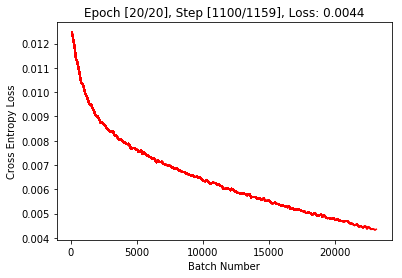

CPU times: user 7min 43s, sys: 1min 18s, total: 9min 2s
Wall time: 7min 37s


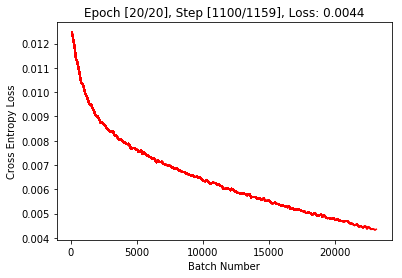

In [214]:
%time train()

In [215]:
#save the weights for newly trained model
torch.save(DPMnet.state_dict(), 'DPMnet_50_0.0003_2.pkl')

In [196]:
Dnet = CustomDPM(num_classes = 1298)
if(torch.cuda.is_available() and use_gpu):
    Dnet.cuda()

In [168]:
Dnet.load_state_dict(torch.load('DPMnet_50_0.0003_2.pkl'))

In [169]:
def ImageToVec(model, dataset, loader, filename):
    image_labels = list()
    num_images = dataset.__len__()
    print(num_images)
    image_mat = np.zeros((num_images, num_patches_per_image*(hog_size+2) ))
    for i, (images ,labels) in enumerate(loader):  
        # Convert torch tensor to Variable
        images = Variable(images[0]).float()
        if(use_gpu):
            images=images.cuda()
        # Forward + Backward + Optimize        
        outputs = model(images)
        image_patches = outputs.data.cpu().numpy()
        image_vec = np.reshape(image_patches, (1, -1)) #flatten the patches into a 1d vector
        image_mat[i] = image_vec
        image_labels = image_labels + [labels[0]]
        print(i)
    image_labels = np.array(image_labels).astype(int)
    np.savetxt(filename + '_mat.txt', image_mat)
    np.savetxt(filename + '_labels.txt', image_labels)
    
        


In [170]:
%time ImageToVec(Dnet, test_vi_dataset, test_vi_loader, "image")

514
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [171]:
# image_mat = np.loadtxt('image_mat.txt',dtype=np.float32)
# image_labels = np.loadtxt('image_labels.txt', dtype=np.int32)

In [172]:
# img_mat_norm = LA.norm(image_mat, axis=1).reshape((-1,1))
# n_img_mat = np.divide(image_mat, img_mat_norm)
# print(img_mat_norm)

In [173]:
net_weights = torch.load('DPMnet_50_0.0003.pkl')

In [174]:
print(net_weights)
# for param in DPMnet.parameters():
#     print(param.data)

OrderedDict([('linear1.weight', 
 3.9179e-02 -8.3132e-02  5.0568e-03  ...  -4.0279e-02  6.7216e-02  2.3972e-02
-4.4562e-02 -3.8204e-02  2.9851e-02  ...   6.4912e-02 -8.2164e-02  6.3330e-02
 1.4037e-02 -1.7900e-02  1.5465e-02  ...   6.3803e-03 -6.4747e-02  5.9897e-02
                ...                   ⋱                   ...                
-6.4881e-02  6.6055e-02  4.7231e-02  ...  -4.2722e-02  7.0227e-02 -1.5397e-02
 8.7685e-03 -5.0644e-03 -2.2826e-02  ...   2.3638e-02  5.0757e-02  4.8623e-02
-4.3591e-02 -3.4707e-02 -4.8007e-02  ...  -3.0646e-02  2.6630e-02  6.5219e-02
[torch.cuda.FloatTensor of size 200x1298 (GPU 0)]
), ('linear1.bias', 
1.00000e-02 *
 -0.8838
  0.9953
  1.6252
 -0.6679
 -3.1303
  0.5518
 -3.1998
 -4.0425
  1.1778
 -1.5447
 -0.2594
 -1.7771
  1.2098
  0.5935
 -2.2161
  1.7138
  2.3254
  2.4096
  1.2606
  0.9372
 -0.7406
 -2.8326
  2.0533
  0.1544
  1.8228
 -1.8553
 -2.8161
 -3.3940
  1.7690
 -0.4521
 -1.3498
 -2.5588
  3.0573
 -0.7261
 -0.3824
 -1.4826
 -2.3704
  2

Test the finetuned model

In [175]:
def test( dataset, loader, filename):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    image_labels = list()
    correct = 0
    total = 0
    
    num_images = dataset.__len__()
    image_mat = np.zeros((num_images, num_patches_per_image*(hog_size+2) ))
    
    for i,(images, labels) in enumerate(loader):
        images = images[0].numpy()
        print(i)
        image_vec = np.reshape(images, (1, -1)) #flatten the patches into a 1d vector
        image_mat[i] = image_vec
        image_labels = image_labels + [labels[0]]
    
    image_data = np.loadtxt(filename + '_mat.txt',dtype=np.float32)
    image_data_labels = np.loadtxt(filename + '_labels.txt', dtype=np.int32)
    print("train set loaded")
    img_mat_norm = LA.norm(image_mat, axis=1).reshape((-1,1))
    n_img_mat = np.divide(image_mat, img_mat_norm)
    y = np.matmul(n_img_mat, np.transpose(image_data))
    np.savetxt('dot-product.txt',y)
    predicted = image_data_labels[np.argmax(y, axis=1)]
#     _, predicted = torch.max(outputs.data, 1)
    np.savetxt(filename + '_predictions.txt', predicted)
    np.savetxt(filename + '_test_labels.txt', image_labels)
    total = num_images
    correct = (predicted == image_labels).sum()
    print('Accuracy of the network on the images: %d %%' % (100 * correct/total ))
    


In [176]:
#test the retrained model
%time test(test_ir_dataset, test_ir_loader, "image")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#### Training from scratch
Now we shall try training the model from scratch and observe the differences.

In [177]:
%time ImageToVec(Dnet, test_vi_dataset_tr, test_vi_loader_tr, "train_image")

1159
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [178]:
#test the  model on training data
%time test(test_ir_dataset_tr, test_ir_loader_tr, "train_image")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [161]:
# Reinstantiate the model and optimizer
# model = CustomResnet(num_classes = 10)
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)# Use Adam optimizer, use learning_rate hyper parameter
# print(torch.cuda.is_available)
# if(torch.cuda.is_available() and use_gpu):
#     model.cuda()




In [162]:
#save the weights for newly trained model
# torch.save(DPMnet.state_dict(), 'DPMnet_1.pkl')

In [15]:
# Test
# %time test()

Accuracy of the network on the 10000 test images: 92 %
CPU times: user 732 ms, sys: 60 ms, total: 792 ms
Wall time: 789 ms


This is the end of Assignment 1